# Beams Comparison

## 1. Introduction:

* Briefly introduce two beam theories.
* Compare analytical solutions for Euler-Benoulli beams and Timoshenko beams under uniformly distributed load.
* Implement FEM on Timoshenko beams with linear and quadratic elements.
* Illustrate that the shear locking effect can be mitigated by using higher-order basis functions.




## 2. Theoretical Background

This section briefly introduces the assumptions and governing equations of the two beam theories.
### 2.1 Euler-Bernoulli Beam Theory
The Euler-Bernoulli beam is assumed to be thin and straight [1], and the effects of transverse shear deformations from the shear forces are neglected [1,2]. Deformations are only caused by normal forces to the cross section of the beam [1].
For cross sections, an assumption is made that plane sections, initially orthogonal to the beam's longitudinal axis, remain both planar and orthogonal to the deformed axis following bending [2]. The deformations are assumed to be infinitesimal [2]. Lastly, the beam is made of an isotropic, elastic, and homogeneous material [2].\
Below is the formula for the Euler-Bernoulli beam under a uniformly-distributed transverse force [3]:
$$
w_{EB}(x) = \frac{q_0}{24EI} (x^4 - 4Lx^3 + 6L^2x^2)
$$
,where $w_{EB}(x)$ is the transverse deflection of the beam. $q_0$ denotes the distributed transverse load per unit length acting on the beam. $L$ is the length of the beam.
### 2.2 Timoshenko Beam Theory
Unlike the Euler-Bernoulli beam, a first order correction is introduced into the Timoshenko beam for transverse shear effects [2]. The shear stress and strain distributions are assumed to be constant over the cross sections of the beam [1].
The formula for the Timoshenko beam under a uniformly-distributed transverse force is [1]:
$$
w_{Timoshenko}(x) = \frac{q_0}{24 E I} \left( {x^4} - {4 L x^3} + {6 L^2 x^2} \right)+\frac{q_0}{\alpha G A} \left( L x - \frac{x^2}{2} \right)
$$
$$
\beta(x) = -\frac{q_0 x}{6 E I} \left(3 L^2 - 3 L x + x^2\right)
$$
,where $\alpha$ is the shear correction factor ($\frac{5}{6}$ for a rectangular beam cross section). $\beta(x)$ is the rotation angle of the cross section. \
For the shear locking phenomenon of the Timoshenko beam when using linear elements, it can be observed in the thin beam limit. The locking phenomenon results from inconsistent interpolation for $w$ and $\beta$ [4].

## 3. Numerical Implementation: Finite Element Method (FEM)

### 3.1 Define Beam Properties

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.integrate import quad

In [2]:
# Define beam properties
t = 0.05  # Thickness
b = 0.5  # Width
L = 5  # Length of the beam
E = 70e9  # Young's modulus
I = 1/12*b*t**3  # Area moment of inertia
A = b*t  # Cross-sectional area (for Timoshenko shear effects)
G = E / (2 * (1 + 0.3)) # Shear modulus (assuming Poisson's ratio = 0.3)
alpha = 5/6 # Shear correction factor for rectangular cross-section (0.9 for circular)

# Define load: uniformaly distributed transverse force
q0 = -10 # N/m
q = sp.S(q0)
m = 0
f = sp.Matrix([
  [q],
  [m]
  ])

### 3.2 Calculate the Analytical Solutions from the Two Beam Theories

In [3]:
# --- Euler-Bernoulli Beam Theory Deflection ---
x_val = np.linspace(0, L, 100)
w_EB = q0*x_val**2*(6*L**2-4*L*x_val+x_val**2)/(24*E*I)

# --- Timoshenko Beam Theory Deflection ---
w_Timoshenko = (6*q0*L**2*x_val**2 - 4*q0*L*x_val**3 + q0*x_val**4)/(24*E*I) - ((q0*x_val**2)/2-(L*q0*x_val))/(A*G*alpha)


### 3.3 Define Utility Functions

In [4]:
def integrate_sympy_matrix_numerically(sympy_matrix, integration_variable, lower_limit, upper_limit):
  """
  Numerically integrates a SimPy Matrix element-wise using scipy.integrate.quad.

  Args:
      sympy_matrix (sympy.Matrix): The SimPy Matrix to integrate.
      integration_variable (sympy.Symbol): The variable with respect to which to integrate.
      lower_limit (float): The lower limit of integration.
      upper_limit (float): The upper limit of integration.

  Returns:
      numpy.ndarray: A NumPy array containing the numerical results of the integration
                      for each element of the input matrix. The shape of the output
                      array will match the shape of the input SimPy Matrix.
  """
  rows = sympy_matrix.rows
  cols = sympy_matrix.cols
  integrated_array = np.zeros((rows, cols), dtype=float)

  for i in range(rows):
    for j in range(cols):
      expr = sympy_matrix[i, j]
      numerical_func = sp.lambdify(integration_variable, expr, modules=['numpy'])
      integral_value, _ = quad(numerical_func, lower_limit, upper_limit)
      integrated_array[i, j] = integral_value

  return integrated_array

In [5]:
def visually_show_nonzero_elements(matrix, title='Visualization of Non-Zero Elements'):
  """
  Visually shows the non-zero elements of a NumPy array (n x n matrix).

  Args:
      matrix (np.ndarray): The input n x n NumPy array.
  """
  if matrix.ndim != 2 or matrix.shape[0] != matrix.shape[1]:
      raise ValueError("Input must be a square 2D NumPy array.")

  masked_matrix = np.ma.masked_where(matrix == 0, matrix)

  plt.imshow(masked_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar(label='Non-zero Value')
  plt.title(title)
  plt.xticks([])
  plt.yticks([])
  plt.show()

### 3.4 Calculate the Transverse Deflection of the Timoshenko Beam with Linear Elements

In [6]:
# --- Linear Finite Elements ---
def Timoshenko_Beam_with_Linear_Elements(n_elements=10, load_vactor=f, L=L, E=E, I=I, A=A, G=G, alpha=alpha):
  nodes_per_element = 2
  dofs_per_node = 2  # Vertical displacement and rotation
  nodes_linear = np.linspace(0, L, n_elements + 1)
  n_nodes = len(nodes_linear)
  n_dofs = n_nodes * dofs_per_node
  x, xi = sp.symbols('x xi')  # symbolic variables
  K_global = np.zeros((n_dofs, n_dofs))
  f_global = np.zeros((n_dofs, 1))

  # 1. Find the global stiffness matrix K_global and load vector f_global
  x, xi = sp.symbols('x xi')      # symbolic variables
  K_global = np.zeros((n_dofs, n_dofs)) # Initialize the global stiffness matrix
  f_global = np.zeros((n_dofs, 1))   # Initialize the global nodal force vector
  for i in range(n_elements):
    #print("Element No.",i)
    # 1-1 Find the element stiffness matrix K_e
    # Acquire nodal information of element i
    node_i = i
    node_j = node_i + 1
    x_i = nodes_linear[node_i] # physical coordinate of the first node
    x_j = nodes_linear[node_j] # physical coordinate of the second node
    L_e = x_j - x_i  # length of element i

    # Define the basis functions using linear Lagrange Polynomials
    N1 = (1 - xi)/2
    N2 = (1 + xi)/2
    N = sp.Matrix([
      [N1, 0, N2, 0],
      [0, N1, 0, N2]
    ])
    #print("N:",N)

    # Define the geometry parametrization at element i using the shape
    # functions above
    x = N1*x_i + N2*x_j
    #print("x:",x)

    # Define the Jacobian of mapping from reference element to
    # physical coordinates
    J = sp.diff(x, xi)
    #print("J:",J)

    # Differentiate the basis functions w.r.t. the physical space
    dN1 = sp.diff(N1, xi)*(1/J)
    dN2 = sp.diff(N2, xi)*(1/J)
    #print("dN1:",dN1)
    #print("dN2:",dN2)

    # Define the B-operator matrix
    # L = [[d/dx 1],
    #    [0 d/dx]]]
    # B = L*N
    B = sp.Matrix([
      [dN1, N1, dN2, N2],
      [0,  dN1, 0, dN2]
    ])

    # Define the constitutive law
    C = sp.Matrix([
      [alpha*G*A, 0],
      [0,     E*I]
    ])
    #print("C:",C)

    # Define the integrand of the element stiffness matrix
    K_e_int = (B.T * C * B) * J
    #print("K_e_int:",K_e_int)

    # Integrate for the element stiffness matrix
    K_e = sp.integrate(K_e_int, (xi, -1, 1))
    K_e_np = np.array(K_e.evalf(), dtype=float)
    #K_e_np = integrate_sympy_matrix_numerically(K_e, xi, -1, 1)
    #print("K_e:",K_e)
    #print("K_e_np:", K_e_np)
    #print()

    # 1-2. Find the element consistent nodal force vector f_e
    # Define the integrand of the element consistent nodal force vector f_e_int
    f_e_int = N.T*f * J

    # Integrate for the element consistent nodal force vector f_e
    f_e = sp.integrate(f_e_int, (xi, -1, 1))
    f_e_np = np.array(f_e.evalf(), dtype=float)
    #print("f_e:",f_e)
    #print("f_e_np:",f_e_np)

    # Assemble the global stiffness matrix K and the load factor K
    target_dof_map = [2*node_i, 2*node_i+1, 2*node_j, 2*node_j+1]
    for a in range(nodes_per_element*dofs_per_node):
      f_global[target_dof_map[a]] += f_e_np[a]
      for b in range(nodes_per_element*dofs_per_node):
        K_global[target_dof_map[a], target_dof_map[b]] += K_e_np[a, b]

  # 2. Solve for u, the displacement and rotation fields
  # Apply boundary conditions (fixed at node 0)
  # DOFs 0 and 1 are fixed: displacement and rotation
  K_mod = K_global[2:, 2:]
  f_mod = f_global[2:]
  #print ("K_mod:", K_mod)
  #print ("f_mod:", f_mod)

  # Solve for displacements
  u = np.zeros((n_dofs, 1))
  u_free = solve(K_mod, f_mod)
  u[2:] = u_free
  #print("u:",u)
  return nodes_linear, u, K_mod, f_mod

In [7]:
nodes_linear, u_linear, K_mod, f_mod = Timoshenko_Beam_with_Linear_Elements(n_elements=20, load_vactor=f)

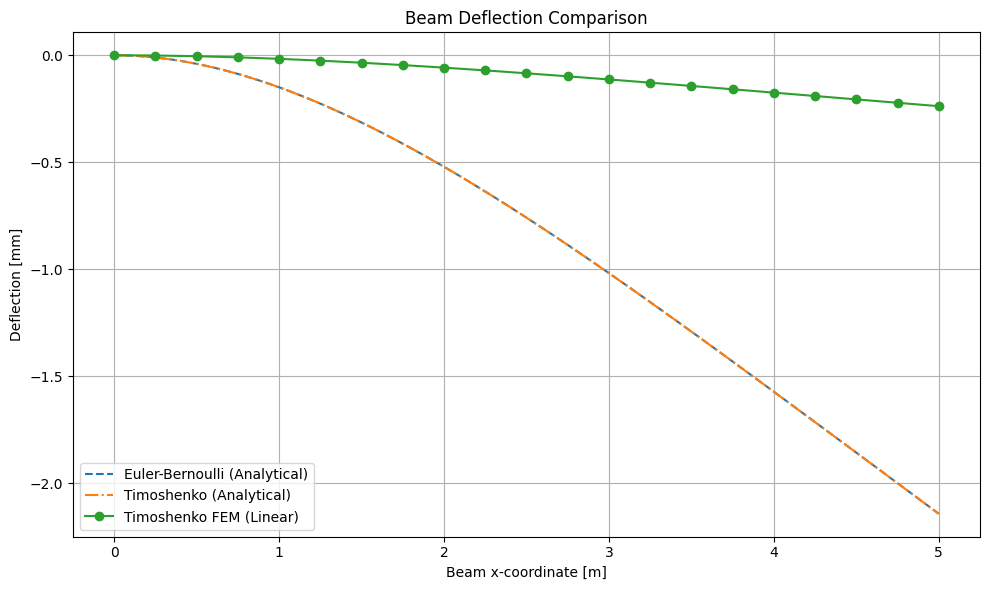

In [8]:
# Compare the results
# Extract vertical displacements from FEM
w_FEM_linear = u_linear[0::2].flatten()

# Plot
plt.figure(figsize=(10,6))
plt.plot(x_val, w_EB*1e3, label='Euler-Bernoulli (Analytical)', linestyle='--')
plt.plot(x_val, w_Timoshenko*1e3, label='Timoshenko (Analytical)', linestyle='-.')
plt.plot(nodes_linear, w_FEM_linear*1e3, label='Timoshenko FEM (Linear)', marker='o')
plt.xlabel('Beam x-coordinate [m]')
plt.ylabel('Deflection [mm]')
plt.title('Beam Deflection Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#visually_show_nonzero_elements(K_mod, "Visualization of Non-zero Elements in K_mod")

### 3.5 Calculate the Transverse Deflection of the Timoshenko Beam with Quadratic Elements

In [9]:
# --- Quadratic Finite Elements ---
def Timoshenko_Beam_with_Quadratic_Elements(n_elements=5, load_vactor=f, L=L, E=E, I=I, A=A, G=G, alpha=alpha):
  # For quadratic elements
  nodes_per_element = 3
  dofs_per_node = 2  # Vertical displacement and rotation
  nodes_quadratic = np.linspace(0, L, 2*n_elements + 1)
  n_nodes = len(nodes_quadratic)
  n_dofs = n_nodes * dofs_per_node
  x, xi = sp.symbols('x xi')  # symbolic variables
  K_global = np.zeros((n_dofs, n_dofs))
  f_global = np.zeros((n_dofs, 1))

  # 1. Find the global stiffness matrix K_global and load vector f_global
  x, xi = sp.symbols('x xi')      # symbolic variables
  K_global = np.zeros((n_dofs, n_dofs)) # Initialize the global stiffness matrix
  f_global = np.zeros((n_dofs, 1))   # Initialize the global nodal force vector
  for i in range(n_elements):
    #print("Element No.",i)
    # 1-1 Find the element stiffness matrix K_e
    # Acquire nodal information of element i
    node_i  = i*(nodes_per_element-1) # The boundary node of element i
    node_mid = node_i + 1
    node_j  = node_i + 2
    x_i = nodes_quadratic[node_i]   # physical coordinate of the first node
    x_mid = nodes_quadratic[node_mid] # physical coordinate of the second (mid) node
    x_j = nodes_quadratic[node_j]   # physical coordinate of the third node
    L_e = x_j - x_i  # length of element i
    #print("node: ", node_i, node_mid, node_j)

    # Define the basis functions using linear Lagrange Polynomials
    N1 = ((xi -  0)*(xi - 1))/((-1 -  0)*(-1 - 1))
    N2 = ((xi - (-1))*(xi - 1))/((0 - (-1))*(0 - 1)) # mid
    N3 = ((xi - (-1))*(xi - 0))/((1 - (-1))*(1 - 0))
    N = sp.Matrix([
      [N1, 0, N2, 0, N3, 0],
      [0, N1, 0, N2, 0, N3]
    ])
    #print("N:",N)

    # Define the geometry parametrization at element i using the shape
    # functions above
    x = N1*x_i + N2*x_mid + N3*x_j
    #print("x:",x)

    # Define the Jacobian of mapping from reference element to
    # physical coordinates
    J = sp.diff(x, xi)
    #print("J:",J)

    # Differentiate the basis functions w.r.t. the physical space
    dN1 = sp.diff(N1, xi)*(1/J)
    dN2 = sp.diff(N2, xi)*(1/J)
    dN3 = sp.diff(N3, xi)*(1/J)
    #print("dN1:",dN1)
    #print("dN2:",dN2)

    # Define the B-operator matrix
    # L = [[d/dx 1],
    #    [0 d/dx]]]
    # B = L*N
    B = sp.Matrix([
      [dN1, N1, dN2, N2, dN3, N3],
      [0,  dN1, 0, dN2,  0, dN3]
    ])

    # Define the constitutive law
    C = sp.Matrix([
      [alpha*G*A, 0],
      [0,     E*I]
    ])
    #print("C:",C)

    # Define the integrand of the element stiffness matrix
    K_e_int = (B.T * C * B) * J
    #print("K_e_int:",K_e_int)

    # Integrate for the element stiffness matrix
    #K_e = sp.integrate(K_e_int, (xi, -1, 1))
    #K_e_np = np.array(K_e.evalf(), dtype=float)
    K_e_np = integrate_sympy_matrix_numerically(K_e_int, xi, -1, 1)
    #print("K_e_np:",K_e_np)
    #print("K_e:",K_e)
    #print()

    # 1-2. Find the element consistent nodal force vector f_e
    # Define the integrand of the element consistent nodal force vector f_e_int
    f_e_int = N.T*f * J

    # Integrate for the element consistent nodal force vector f_e
    f_e = sp.integrate(f_e_int, (xi, -1, 1))
    f_e_np = np.array(f_e.evalf(), dtype=float)
    #print("f_e:",f_e)
    #print("f_e_np:",f_e_np)

    # Assemble the global stiffness matrix K and the load factor K
    target_dof_map = [2*node_i, 2*node_i+1, 2*node_mid, 2*node_mid+1, 2*node_j, 2*node_j+1]
    for a in range(nodes_per_element*dofs_per_node):
      f_global[target_dof_map[a]] += f_e_np[a]
      for b in range(nodes_per_element*dofs_per_node):
        K_global[target_dof_map[a], target_dof_map[b]] += K_e_np[a, b]
    #print("K_global:",K_global)
    #visually_show_nonzero_elements(K_global)
  # 2. Solve for u, the displacement and rotation fields
  # Apply boundary conditions (fixed at node 0)
  # DOFs 0 and 1 are fixed: displacement and rotation
  K_mod = K_global[2:, 2:]
  f_mod = f_global[2:]
  #print("K_mod:", K_mod)
  #print("f_mod:", f_mod)
  #print()

  # Solve for displacements
  u = np.zeros((n_dofs, 1))
  u_free = solve(K_mod, f_mod)
  u[2:] = u_free
  #print("u:",u)
  return nodes_quadratic, u, K_mod, f_mod

In [ ]:
nodes_quadratic, u_quadratic, K_mod, f_mod = Timoshenko_Beam_with_Quadratic_Elements(n_elements=10, load_vactor=f)

### 3.6 Comparison of the Transverse Deflection Solved by Analytical and Finite Element Methods

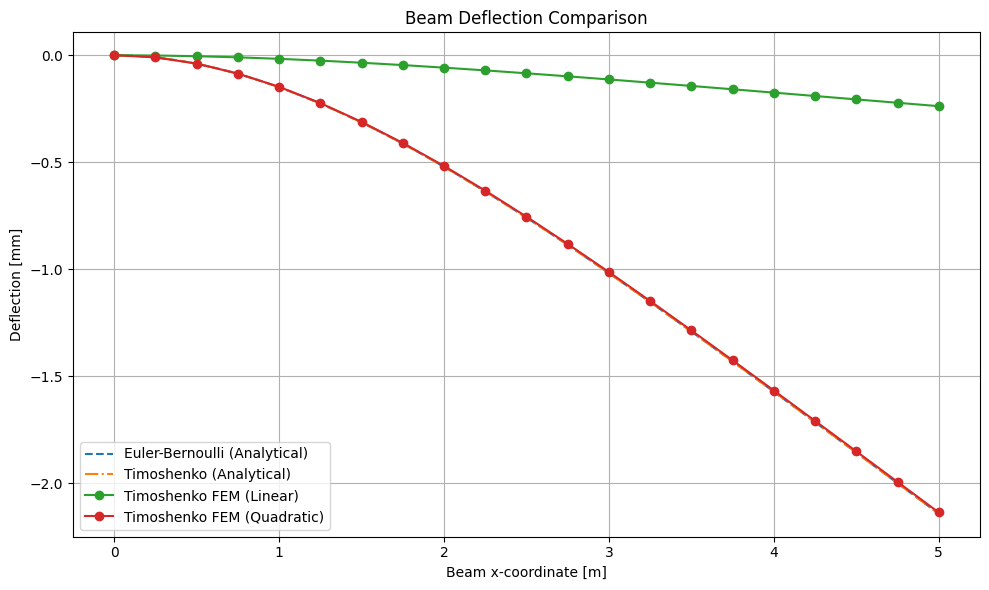

In [11]:
# Compare the results
# Extract vertical displacements from FEM
w_FEM_quadratic = u_quadratic[0::2].flatten()

# Plot
plt.figure(figsize=(10,6))
plt.plot(x_val, w_EB*1e3, label='Euler-Bernoulli (Analytical)', linestyle='--')
plt.plot(x_val, w_Timoshenko*1e3, label='Timoshenko (Analytical)', linestyle='-.')
plt.plot(nodes_linear, w_FEM_linear*1e3, label='Timoshenko FEM (Linear)', marker='o')
plt.plot(nodes_quadratic, w_FEM_quadratic*1e3, label='Timoshenko FEM (Quadratic)', marker='o')
plt.xlabel('Beam x-coordinate [m]')
plt.ylabel('Deflection [mm]')
plt.title('Beam Deflection Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#visually_show_nonzero_elements(K_mod, "Visualization of Non-zero Elements in K_mod")

In [12]:
# Calculate the differences in edge deflections
print(f"Error (Linear Elements):      {abs((w_FEM_linear[-1]-w_Timoshenko[-1])/w_Timoshenko[-1]*100):.0f}%")
print(f"Error (Quadratic Elements): {abs((w_FEM_quadratic[-1]-w_Timoshenko[-1])/w_Timoshenko[-1]*100):.2f}%")

Error (Linear Elements):      89%
Error (Quadratic Elements): 0.29%


## 4. Discussion

In the above figure, The Timoshenko beam with linear elements underestimates the deflection with an error of 89% to the analytical solution, while the one with quadratic elements shows a close approximation with 0.29% error. In this study, a Timoshenko beam meshed with quadratic elements appears to be more accurate than the linear elements with the same amount of nodes.

## Reference

[1] Öchsner, Andreas. Classical beam theories of structural mechanics. Vol. 42. Cham: Springer, 2021. https://doi.org/10.1007/978-3-030-76035-9. \
[2] Felippa, Carlos A. "Introduction to finite element methods." University of Colorado 885 (2004).\
[3] Hibbeler, R. C. Mechanics of Materials. 10th ed., Pearson, 2018.\
[4] Reddy, J. "On locking-free shear deformable beam finite elements." Computer methods in applied mechanics and engineering, 149(1-4), (1997): 113-132.